In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable

from modules.stn import STN
from modules.gridgen import GridGen

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
img = Image.open('cat.jpg').convert('RGB')

In [4]:
img = np.array(img)/255.0

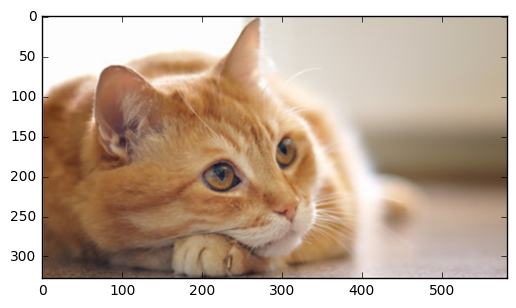

In [5]:
plt.imshow(img)

In [6]:
img_batch = np.expand_dims(img, 0)

In [7]:
inputImages = torch.from_numpy(img_batch.astype(np.float32))

In [8]:
inputImages.size()

torch.Size([1, 328, 582, 3])

In [9]:
grid = np.zeros(img_batch.shape[0:3] + (2,))

In [10]:
grid[:,:,:,0] = np.expand_dims(np.repeat(np.expand_dims(np.arange(328), 0), repeats = 582, axis = 0).T, 0)/328.0 *2 -1 
grid[:,:,:,1] = np.expand_dims(np.repeat(np.expand_dims(np.arange(582), 0), repeats = 328, axis = 0), 0)/582.0  *2 -1

In [11]:
grid_ = torch.from_numpy(grid.astype(np.float32))
grid_ = grid_*2

In [12]:
input1, input2 = Variable(inputImages, requires_grad=True), Variable(grid_, requires_grad=True)


In [13]:
s = STN()
out = s(input1, input2)

In [14]:
res = out.data.numpy()

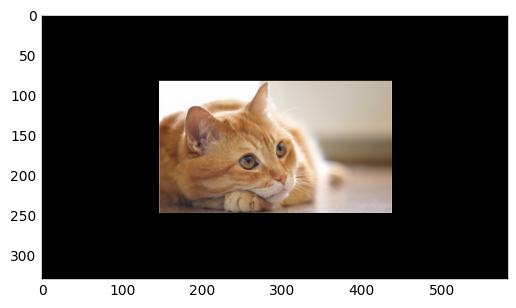

In [15]:
plt.imshow(res[0])

In [16]:
input2

Variable containing:
( 0 , 0 ,.,.) = 
 -2.0000 -2.0000
 -2.0000 -1.9931
 -2.0000 -1.9863
       ⋮        
 -2.0000  1.9794
 -2.0000  1.9863
 -2.0000  1.9931

( 0 , 1 ,.,.) = 
 -1.9878 -2.0000
 -1.9878 -1.9931
 -1.9878 -1.9863
       ⋮        
 -1.9878  1.9794
 -1.9878  1.9863
 -1.9878  1.9931

( 0 , 2 ,.,.) = 
 -1.9756 -2.0000
 -1.9756 -1.9931
 -1.9756 -1.9863
       ⋮        
 -1.9756  1.9794
 -1.9756  1.9863
 -1.9756  1.9931
    ... 

( 0 ,325,.,.) = 
  1.9634 -2.0000
  1.9634 -1.9931
  1.9634 -1.9863
       ⋮        
  1.9634  1.9794
  1.9634  1.9863
  1.9634  1.9931

( 0 ,326,.,.) = 
  1.9756 -2.0000
  1.9756 -1.9931
  1.9756 -1.9863
       ⋮        
  1.9756  1.9794
  1.9756  1.9863
  1.9756  1.9931

( 0 ,327,.,.) = 
  1.9878 -2.0000
  1.9878 -1.9931
  1.9878 -1.9863
       ⋮        
  1.9878  1.9794
  1.9878  1.9863
  1.9878  1.9931
[torch.FloatTensor of size 1x328x582x2]

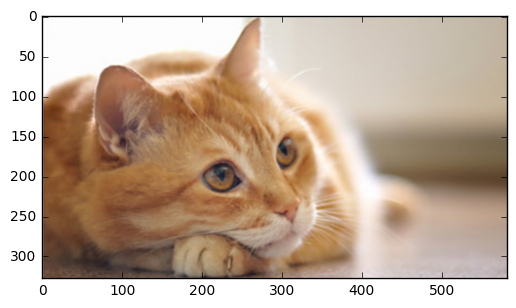

In [25]:
g = GridGen(328, 582)
input = Variable(torch.from_numpy(np.array([[[1, 0, 0], [0, 1, 0]]], dtype=np.float32)), requires_grad = True)
#print input
out = g(input)
res = s(input1, out)
res = res.data.numpy()
plt.imshow(res[0])

In [ ]:
out.size()

In [ ]:
input1[0].size()[1]

In [ ]:
torch.zeros(input1.size() + torch.Size([1])).size()

In [ ]:
t = torch.Size([1])

In [ ]:
t

In [ ]:
torch.Size([1])